<a href="https://colab.research.google.com/github/abhipise2704/Deep_Learning-/blob/master/CNN_CIFAR_10_ASSIGNMENT_abhipise2704_gmail_com_27_(1)_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
import tensorflow as tf
import keras
tf.keras.backend.clear_session
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras import models, layers
from keras.models import Model
from keras.layers import BatchNormalization, Activation, Flatten
from keras.optimizers import Adam
from matplotlib import pyplot
#from scipy.misc import toimage
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import optimizers
from tensorflow import keras
from keras import backend as k
import tensorflow as tf

Using TensorFlow backend.


1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [5]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [7]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [8]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 6s 0us/step


In [9]:
print(X_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 10)


In [10]:
X_test.shape

(10000, 32, 32, 3)

In [11]:
print("="*40)
print("X_train shape: ",X_train.shape,"\ny_train shape :",y_train.shape)
print("-"*40)
print("X_test shape: ",X_test.shape,"\ny_test shape :",y_test.shape)
print("="*40)

X_train shape:  (50000, 32, 32, 3) 
y_train shape : (50000, 10)
----------------------------------------
X_test shape:  (10000, 32, 32, 3) 
y_test shape : (10000, 10)


In [12]:
X_train.max()

255

In [13]:
X_train.min()

0

In [14]:
# if we observe the above matrix each cell is having a value between 0-255
# before we move to apply machine learning algorithms lets try to normalize the data
# X => (X - Xmin)/(Xmax-Xmin) = X/255

X_train = X_train/255
X_test = X_test/255

In [15]:
print(X_train.max())
print(X_train.min())

1.0
0.0


In [16]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [17]:
num_filter = 11
dropout_rate = 0
l = 40
reg=l2(1e-4)


input = layers.Input(shape=(32, 32, 3,))

First_Block = denseblock(input, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [18]:
#https://arxiv.org/pdf/1608.06993.pdf
#from IPython.display import IFrame, YouTubeVideo
#YouTubeVideo(id='-W6y8xnd--U', width=600)

In [19]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 3)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 5)    135         activation[0][0]                 
______________________________________________________________________________________________

In [20]:
# summarize the model
#from tensorflow.keras.utils import plot_model

#plot_model(model, 'model_cifar.png', show_shapes=True)

In [21]:
#https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [22]:
##https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
#callbacks
from time import time
from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard
# tensorboard
# tensor-board in colab
# Refer: https://www.tensorflow.org/tensorboard/get_started
import os
import datetime

#! rm -rf ./logs/ 
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#print(logdir)

#tensorboard = TensorBoard(log_dir=logdir)


checkpoint_save = tf.keras.callbacks.ModelCheckpoint('/content/',
                                                     monitor='val_loss', 
                                                     verbose=0, 
                                                     save_best_only=True,
                                                     mode='max')
history = tf.keras.callbacks.History()
# Define CallBacks

# patient early stopping
#my_callback = MyThresholdCallback(threshold=0.9)

# keras' ReduceLROnPlateau callback default parameters:
#from tf.keras.callbacks import ReduceLROnPlateau

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              verbose=0,
                              mode='auto')

callbacks_list = [checkpoint_save,history,reduce_lr]

In [23]:
#%load_ext tensorboard
#%tensorboard --logdir $logdir

In [24]:
# set up image augmentation
image_aug = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
image_aug.fit(X_train,augment=True, rounds=3)

In [25]:
import matplotlib.pyplot as plt

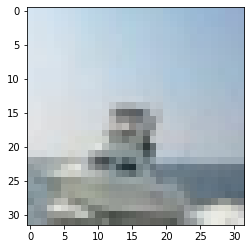

In [26]:
plt.imshow(X_train[100])

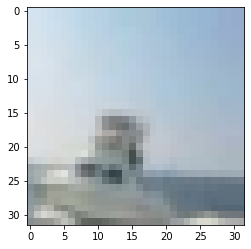

In [27]:
plt.imshow(image_aug.random_transform(X_train[100]))

In [28]:
# determine Loss function and Optimizer
#https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
 #                                                         decay_steps=10000,
  #                                                        decay_rate=0.9)



opt = keras.optimizers.Adam(0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
int(len(X_train) / 16)

3125

In [30]:
 #https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator

history = model.fit(image_aug.flow(X_train, y_train, batch_size=16),
                              steps_per_epoch = int(len(X_train) / 16),
                              epochs=70, 
                              validation_data=(X_test, y_test),
                              callbacks=callbacks_list)

Epoch 1/70
3125/3125 [==============================] - ETA: 0s - loss: 1.8722 - accuracy: 0.3063WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/assets
3125/3125 [==============================] - 375s 120ms/step - loss: 1.8722 - accuracy: 0.3063 - val_loss: 1.7919 - val_accuracy: 0.3455 - lr: 0.0100
Epoch 2/70
3125/3125 [==============================] - 278s 89ms/step - loss: 1.4762 - accuracy: 0.4592 - val_loss: 1.2122 - val_accuracy: 0.5583 - lr: 0.0100
Epoch 3/70
3125/3125 [==============================] - 285s 91ms/step - loss: 1.2560 - accuracy: 0.5470 - val_loss: 1.1698 - val_accuracy: 0.5785 - lr: 0.0100
Epoch 4/70
3125/3125 [===

In [ ]:

 # Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

In [ ]:
import pandas as pd 

In [ ]:
model_perfo=pd.DataFrame(history.history)

In [ ]:
model_perfo

In [ ]:
model_perfo.columns

#'Accuracy (Training & Validation) vs No of Epoch'

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))

plt.plot(model_perfo['accuracy'],
         color='green',
         label='Train_accuracy',
         marker='o', 
         )

plt.plot(model_perfo['val_accuracy'],
         color='red',
         label='val_accuracy',
         marker='o', 
         )

plt.xlabel('no of epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Accuracy (Training & Validation) vs No of Epoch',fontsize=20)
plt.legend()
plt.grid()

#loss (Training & Validation) vs No of Epoch

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))

plt.plot(model_perfo['loss'],
         color='green',
         label='Train_loss',
         marker='o', 
         )

plt.plot(model_perfo['val_loss'],
         color='red',
         label='val_loss',
         marker='o', 
         )

plt.xlabel('no of epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.title('loss (Training & Validation) vs No of Epoch',fontsize=20)
plt.legend()
plt.grid()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred1 = model.predict (X_test, batch_size=128, verbose=0)
rounded_predictions=np.argmax(y_pred1,axis=1)

#https://stackoverflow.com/questions/54589669/confusion-matrix-error-classification-metrics-cant-handle-a-mix-of-multilabel
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

#https://stackoverflow.com/questions/54589669/confusion-matrix-error-classification-metrics-cant-handle-a-mix-of-multilabel
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, rounded_predictions)
print("confusion Matrix= \n",cm)

#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import seaborn as sns

plt.figure(figsize=(15,9))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%',cmap='Blues')
plt.title('Confusion Matrix of model CIFAR10 DENSENET',fontsize=22)
plt.xlabel('Predicted Label',fontsize=16)
plt.ylabel('True Label',fontsize=16)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])